# Image Stitching from Rì Sớt Chơ


/var/folders/v9/7151yn5n24j3trjjwbpjl5rr0000gn/T/ipykernel_44627/2775570108.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  src_img = imageio.imread('/Users/buidat/Documents/Code/code_for_kids/Bai_tap/img11.png') # ảnh trái
/var/folders/v9/7151yn5n24j3trjjwbpjl5rr0000gn/T/ipykernel_44627/2775570108.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tar_img = imageio.imread('/Users/buidat/Documents/Code/code_for_kids/Bai_tap/img12.png') # ảnh phải


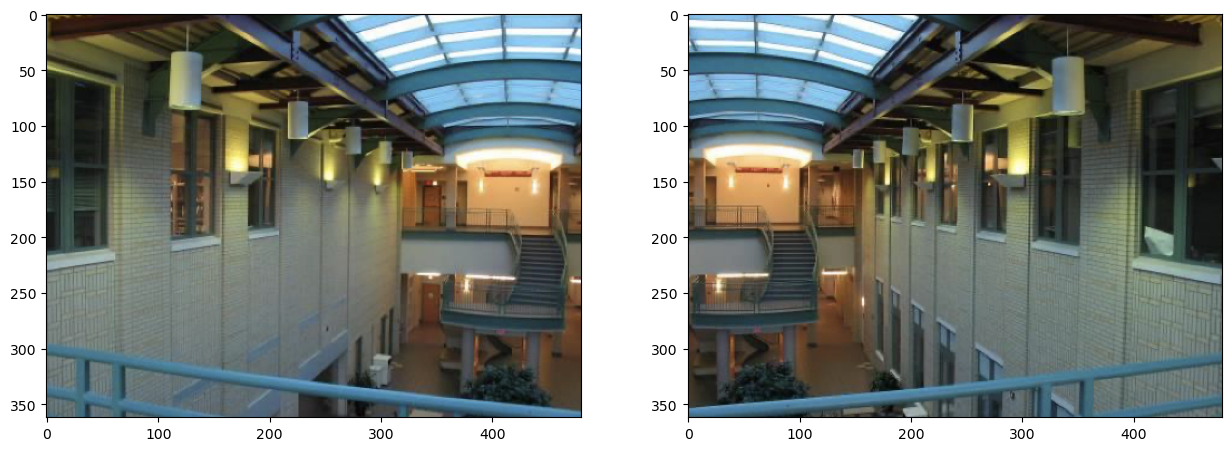

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import imageio

def plot_img(img, size=(7,7), title=""):
    cmap = "gray" if len(img.shape) == 2 else None
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=5, size=7, title=""):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        cmap="gray" if len(img.shape) == 2 else None
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


src_img = imageio.imread('/Users/buidat/Documents/Code/code_for_kids/Bai_tap/img11.png') # ảnh trái
tar_img = imageio.imread('/Users/buidat/Documents/Code/code_for_kids/Bai_tap/img12.png') # ảnh phải

src_gray = cv2.cvtColor(src_img, cv2.COLOR_RGB2GRAY)
tar_gray = cv2.cvtColor(tar_img, cv2.COLOR_RGB2GRAY)
plot_imgs([tar_img, src_img], size=8)

## Phần code SIFT:

In [ ]:
# Thay thế code bên dưới bằng code SIFT của Hưng+Công+Hùng
SIFT_detector = cv2.SIFT_create()
kp1, des1 = SIFT_detector.detectAndCompute(src_gray, None)
kp2, des2 = SIFT_detector.detectAndCompute(tar_gray, None)
print(des1[0])

[  0.   2.  19.  36.  15.   3.   4.   2.  37. 104.  43.  21.  12.   7.
  29.  61.  35.  56.  19.  30.   9.  20.  19.  41.   0.   0.   0.   1.
   1.   2.   0.   0.  25.   1.   0.   3.  19.   9.  14.  42. 136.   5.
   0.   1.   6.  17.  97. 157.  25.   1.   0.   1.  50. 145.  89. 113.
   0.   0.   0.   0.   2.   8.   0.   0.  63.   7.   0.   0.   4.  18.
  11.  18. 157.  44.   0.   4.  13.   6.   4.  69.  80.  10.   0.  21.
 157.  44.   6.  17.   0.   0.   0.   1.   9.   2.   0.   0.  32.   0.
   0.   0.   0.  13.  17.  38. 157.   2.   0.   0.   9.   7.   4.  95.
  65.   1.   0.   3. 122.  74.   9.  18.   0.   0.   0.   0.   6.   5.
   1.   0.]


## Phần code FLANN dùng KD tree: (Done)
## Caution: bài này có sự nhúng tay của AI, thuần chay xin đừng ném đá

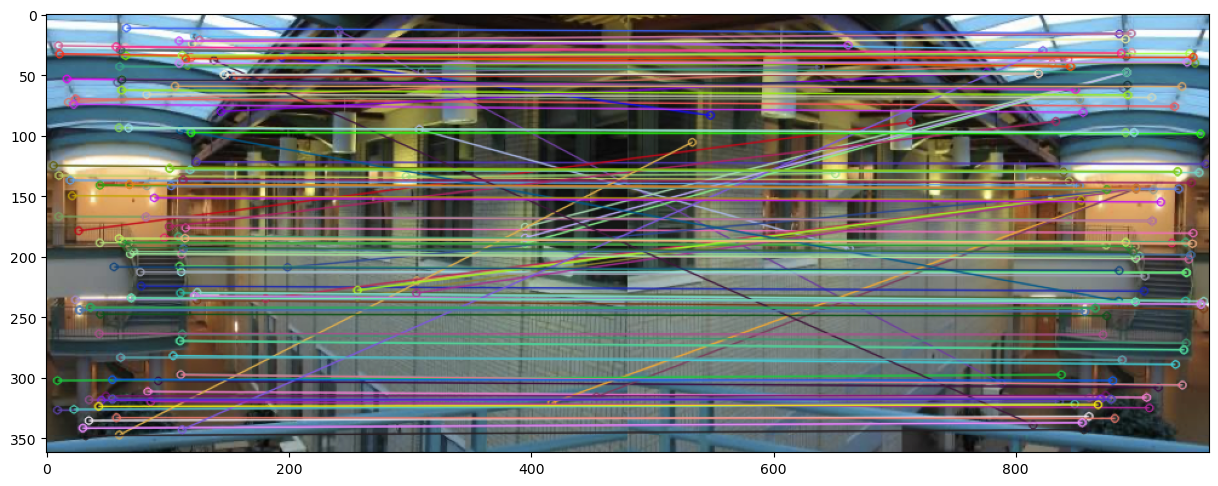

In [ ]:
def convert_to_opencv_dmatch(particle):
    particle = cv2.DMatch(_queryIdx=particle.queryIdx, 
                                          _trainIdx=particle.trainIdx, 
                                          _distance=particle.distance)
    return particle

 # fake kiểu dữ liệu dmatch để chuyển về kiểu dmatch của cv2
class DMatch:
    def __init__(self, queryIdx, trainIdx, distance):
        self.queryIdx = queryIdx
        self.trainIdx = trainIdx
        self.distance = distance

class KDTreeNode:
    def __init__(self, point, index, left=None, right=None):
        self.point = point  # vector tại node này
        self.index = index  # chỉ số của điểm trong dữ liệu gốc
        self.left = left  # cây con bên trái
        self.right = right  # cây con bên phải

class KDTree:
    def __init__(self, points):
        """
        Tạo cây KD từ một danh sách các điểm.
        :param points: Mảng numpy 2D chứa các điểm (vector) trong không gian đa chiều.
        """
        self.root = self._build_tree(points, depth=0)
    
    def _build_tree(self, points, depth):
        """
        Xây dựng cây KD-Tree từ danh sách các điểm.
        :param points: Mảng các điểm cần xây dựng cây.
        :param depth: Chiều hiện tại của cây (depth = 0 tương ứng với trục đầu tiên).
        :return: Node của cây.
        """
        if len(points) == 0:
            return None
        
        # Chọn trục (dimension) để chia, theo chiều sâu (depth)
        k = len(points[0])  # số chiều của vector
        axis = depth % k  # chọn trục theo chiều sâu
        
        # Sắp xếp các điểm theo trục này
        points = sorted(points, key=lambda x: x[0][axis])  # x[0] là điểm gốc, x[1] là chỉ số
        
        # Chọn điểm giữa làm root
        median = len(points) // 2
        
        # Tạo node cho điểm giữa
        node = KDTreeNode(
            point=points[median][0],  # chỉ lưu điểm mà không phải index
            index=points[median][1],  # lưu chỉ số của điểm
            left=self._build_tree(points[:median], depth + 1),
            right=self._build_tree(points[median + 1:], depth + 1)
        )
        return node

    def _distance(self, point1, point2):
        """Tính khoảng cách Euclid giữa hai điểm."""
        return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))
    
    def _find_nearest(self, node, point, depth, best=None):
        """
        Tìm kiếm hai điểm gần nhất trong cây.
        :param node: Node hiện tại trong cây.
        :param point: Điểm truy vấn.
        :param depth: Chiều hiện tại trong cây.
        :param best: Danh sách các điểm gần nhất.
        :return: Hai điểm gần nhất.
        """
        if node is None:
            return best
        
        # Tính khoảng cách từ điểm hiện tại đến điểm truy vấn
        dist = self._distance(node.point, point)
        
        # Cập nhật best nếu cần
        if best is None:
            best = [(dist, node.index)]  # Lưu khoảng cách và chỉ số
        else:
            # Thêm điểm mới nếu khoảng cách nhỏ hơn
            best.append((dist, node.index))
            best = sorted(best, key=lambda x: x[0])[:2]  # Giữ lại 2 điểm gần nhất
        
        # Quyết định đi sang cây con trái hay phải
        k = len(point)
        axis = depth % k
        
        # Kiểm tra trục (axis) và chọn đi tiếp vào cây con trái hay phải
        if point[axis] < node.point[axis]:
            best = self._find_nearest(node.left, point, depth + 1, best)
            if point[axis] + best[0][0] > node.point[axis]:
                best = self._find_nearest(node.right, point, depth + 1, best)
        else:
            best = self._find_nearest(node.right, point, depth + 1, best)
            if point[axis] - best[0][0] < node.point[axis]:
                best = self._find_nearest(node.left, point, depth + 1, best)
        
        return best

    def find_nearest(self, point):
        """
        Tìm kiếm hai điểm gần nhất với điểm truy vấn.
        :param point: Điểm truy vấn (mảng numpy 1D).
        :return: Hai điểm gần nhất cùng với chỉ số của chúng trong danh sách gốc và khoảng cách.
        """
        best = self._find_nearest(self.root, point, depth=0)
        return [(index, dist) for dist, index in best]  # Trả về tuple (index, distance)

# Ví dụ sử dụng KD-Tree
if __name__ == "__main__":
    # Giả sử có một danh sách các điểm trong không gian 2 chiều
    points = des2  # 10 điểm trong không gian 2D
    points_with_index = [(point, idx) for idx, point in enumerate(points)]  # Thêm chỉ số vào mỗi điểm
    
    # Xây dựng KDTree
    tree = KDTree(points_with_index)
    rawMatches = []
    for i in range(len(des1)):
        query_point = des1[i]
        nearest_points_with_index = tree.find_nearest(query_point)
        particle1 = DMatch(i,nearest_points_with_index[0][0],nearest_points_with_index[0][1])
        particle2 = DMatch(i,nearest_points_with_index[1][0],nearest_points_with_index[1][1])
        particle1 = convert_to_opencv_dmatch(particle1)
        particle2 = convert_to_opencv_dmatch(particle2)
        rawMatches.append((particle1,particle2))
    rawMatches = tuple(rawMatches)
    matches = []
    ratio = 0.75

    for m,n in rawMatches:
        # giữ lại các cặp keypoint sao cho với kp1, khoảng cách giữa kp1 với ứng viên 1 nhỏ hơn nhiều so với khoảng cách giữa kp1 và ứng viên 2
        if m.distance < n.distance * ratio:
            matches.append(m)
    matches = sorted(matches, key=lambda x: x.distance, reverse=True)
    matches = matches[:200]
 
    img3 = cv2.drawMatches(src_img, kp1, tar_img, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plot_img(img3, size=(15, 10))

# Phần code tìm Homography matrix bằng RANSAC:

In [ ]:
# Thay phần code Ransac của Hiếu+Hùng
kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])
pts1 = np.float32([kp1[m.queryIdx] for m in matches])
pts2 = np.float32([kp2[m.trainIdx] for m in matches])

# estimate the homography between the sets of points
(H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC)
print(H)


[[ 5.75022359e-01 -1.89536998e-02  3.56476889e+02]
 [-1.44465248e-01  9.36952980e-01  1.36434162e+01]
 [-8.94311831e-04  8.45039167e-06  1.00000000e+00]]


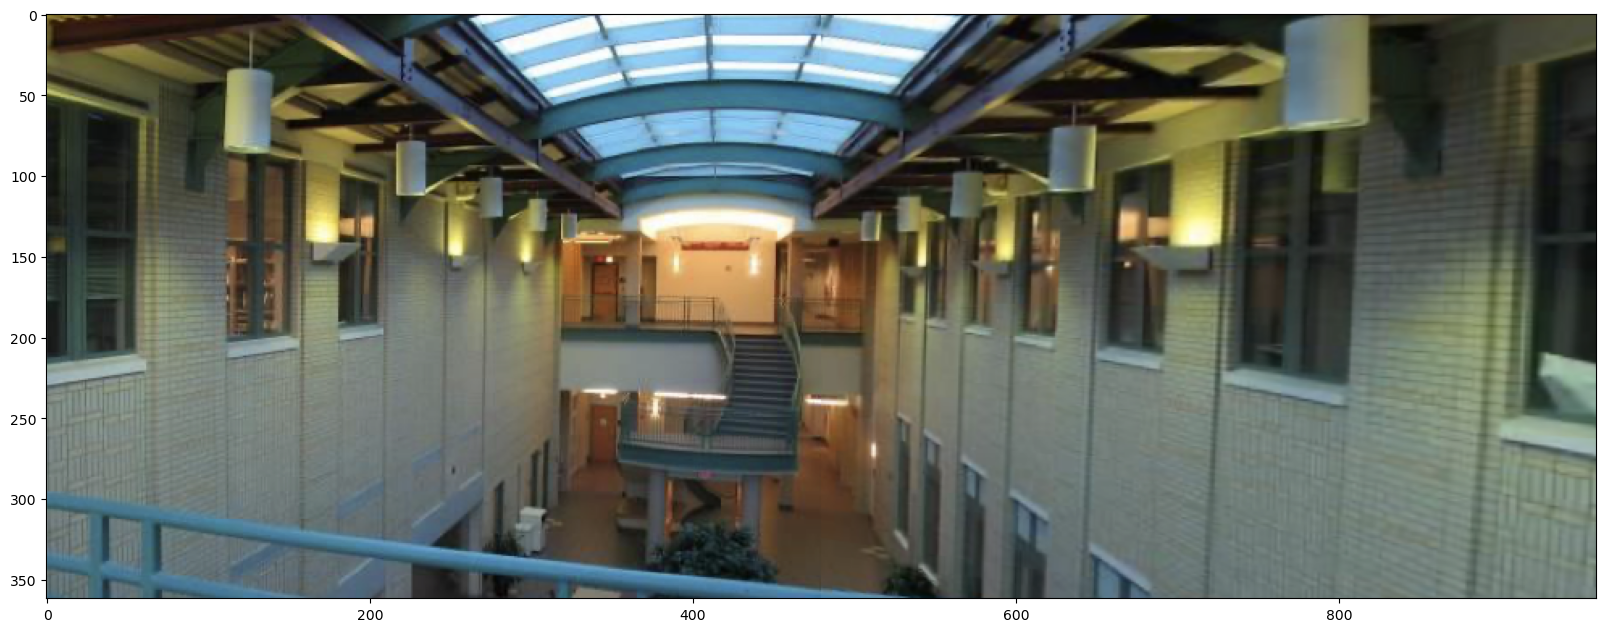

In [6]:
h1, w1 = src_img.shape[:2]
h2, w2 = tar_img.shape[:2]
result = cv2.warpPerspective(src_img, H, (w1+w2, h1))
result[0:h2, 0:w2] = tar_img
plot_img(result, size=(20,10))
